## Introduction to Spark

This introductory module aims to touch upon the interest in using Spark and its use within the datalab. In short, Spark is widely used in massive data processing pipelines (ETL) and allows code to be written in the same way for execution on a single machine by a data scientist or on a cluster with thousands of CPUs. In the context of public statistics, Spark is not a primary skill, especially since data analysis frameworks have greatly improved and no longer require the entire dataset to be loaded into memory for analysis (DuckDB, Arrow, Polars, etc.).

#### Spark Context

Various data analysis methods rely on a Spark context that hides the underlying infrastructure complexity from the data scientist.

This Spark context provides access to a Spark driver (which runs in a Scala JVM) that in turn has access to executors to which jobs will be distributed. These executors are obtained from a resource manager. There are five possibilities:

- **local**: The driver creates threads on the machine using the local CPU.
- **spark standalone**: A basic resource manager provided by Spark.
- **mesos**: The historical resource manager from the University of Berkeley.
- **yarn**: The resource manager present in traditional Big Data infrastructures (e.g., Cloudera/Hortonworks clusters).
- **kubernetes**: The new player, the giant of container orchestration.

#### Development Languages

There are several languages to interact with a Spark driver:
- **Scala** (native: the preferred way)
- **Python** through the PySpark module
- **R** with SparkR, for example
- **Java**

There are even tools that allow interaction solely in SQL with Spark through the Thrift JDBC/ODBC server.

In short, we will focus on **Python** here.

#### Where Are You?

You are on a Docker image built from [this repository](https://github.com/InseeFrLab/images-datascience/tree/main/spark).

You have an installation of Spark and Hadoop, two essential projects in the Big Data ecosystem.

In [2]:
!hadoop version

Hadoop 3.3.6
Source code repository https://github.com/apache/hadoop.git -r 1be78238728da9266a4f88195058f08fd012bf9c
Compiled by ubuntu on 2023-06-18T08:22Z
Compiled on platform linux-x86_64
Compiled with protoc 3.7.1
From source with checksum 5652179ad55f76cb287d9c633bb53bbd
This command was run using /opt/hadoop/share/hadoop/common/hadoop-common-3.3.6.jar


In [3]:
cat /opt/spark/RELEASE

Spark 3.5.1 (git revision fd86f85e) built for Hadoop 3.3.6
Build flags: -Phadoop-provided -Phadoop-cloud -Phive -Phive-thriftserver -Pkubernetes -Pvolcano -Dhadoop.version=3.3.6 -Dhive.version=2.3.9


#### What Are We Going to Do?

In this first module of a long series, we will simply:
* Create a **local Spark context**
* Execute the examples available on the [Spark website](https://spark.apache.org/examples.html)

In [4]:
from pyspark.sql import SparkSession

spark = (SparkSession 
         .builder
         .appName("Introduction")
         .master("local[5]")
         .getOrCreate()
        )
sc = spark.sparkContext

A Spark driver exposes a web UI for monitoring jobs, executors, and more.

The link is available on Onyxia by opening the service and selecting the correct link for the Spark driver.

If everything went well, in the tab you should see a driver with 5 cores and no executors. This is exactly what we requested with a local master. The threads on the driver will do the job.

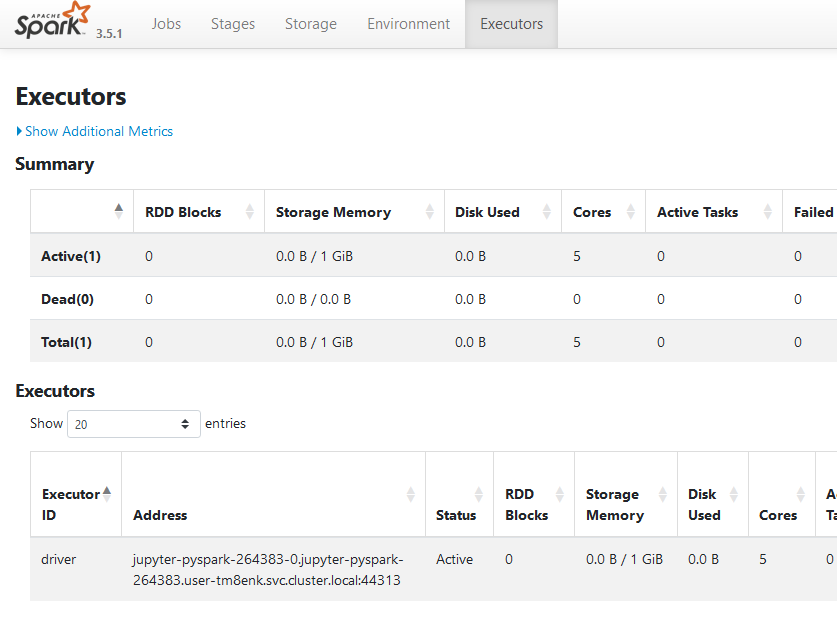

#### Calculating Pi

This is the classic "Hello World" in Spark.

The calculation of Pi is quite amusing, as it involves estimating Pi probabilistically by randomly sampling points from the square [0,1] * [0,1] and observing which ones land inside the quarter circle of radius 1 centered at the point (0,0).

In [7]:
import random

NUM_SAMPLES = 10000000

def inside(p):
    x, y = random.random(), random.random()
    return x*x + y*y < 1

count = sc.parallelize(range(0, NUM_SAMPLES)) \
             .filter(inside).count()
print ("Pi is roughly %f" % (4.0 * count / NUM_SAMPLES))

Pi is roughly 3.141882


The convergence in probability is very slow, which illustrates, if necessary, that just because we distribute computations doesn't mean we're doing something intelligent with them :)

**Technique:** In this example, we distributed the integers from 0 to `NUM_SAMPLES` using the `parallelize` function. In practice, each executor received its batch of integers from the driver. The driver holds the complete list in memory, so this parallelization doesn't really scale well.

#### Wordcount

An ultra-classic example in Big Data, word counting.
We will count the words of this module to see what it discusses.

To do this, we will download a data file using the command-line tool `mc` (available in each datalab service). Of course, it would have been possible to use Python APIs for this.

In [8]:
!mc cp s3/projet-spark-lab/diffusion/formation/data/trump-tweets/trump_insult_tweets_2014_to_2021.csv .

...o_2021.csv: 2.68 MiB / 2.68 MiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 13.93 MiB/s 0s

In [9]:
text_file = sc.textFile("trump_insult_tweets_2014_to_2021.csv")
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b) \
             .sortBy(lambda a : - a[1] )

counts.take(20)



[('the', 16501),
 ('and', 9009),
 ('to', 8773),
 ('of', 7064),
 ('a', 6995),
 ('is', 6904),
 ('in', 4944),
 ('for', 3896),
 ('that', 3405),
 ('are', 3319),
 ('on', 3151),
 ('&', 2914),
 ('I', 2741),
 ('be', 2522),
 ('have', 2464),
 ('with', 2323),
 ('was', 2245),
 ('they', 2114),
 ('Fake', 2009),
 ('will', 1941)]

This shows us many things:
* There's quite a bit of work involved in analyzing and cleaning a text.
* "Fake" seems to be the most represented significant word.

**Technique:** Here, the source is a local file, so each executor must have access to this file locally. It's easy in this case because all the threads are on this driver, but when we distribute the computations across a cluster, we will need to learn how to use remote storage. That will be the focus of the next tutorial.

## Remember to turn off your SparkSession when you're done

In [10]:
spark.stop()